In [107]:
import xarray as xr
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Establishing connection

In [108]:
engine = sqlalchemy.create_engine('sqlite:///exampleco_db.db')

Getting table names

In [109]:
inspector = sqlalchemy.inspect(engine)
tables = inspector.get_table_names()
tables

['feat_0', 'feat_1', 'feat_2', 'feat_3', 'static_data']

Creating pandas dataframes for each feature table (ignoring static for now)

In [110]:
dataframes = []
for table in tables[:-1]:
    dataframes.append(pd.read_sql(table, engine))

## Exploratory Analysis

The IQR is ~0.02, but many of the valid data lies outside this range due to the different opperating modes of the machines. For this reason, IQR shouldn't be used as a cutoff for outliers in this scenario.

In [111]:
dataframes[0]['value'].describe()

count    60000.000000
mean         0.002310
std         57.914469
min       -326.441784
25%         -0.010102
50%          0.000065
75%          0.010212
max        319.144282
Name: value, dtype: float64

Outliers appear to be outside of 3σ ≈ 150. As seen on the plot below, all of the visible outliers are outside of 3 standard deviations, so I will be using 3σ from the mean as the cutoff for determining outliers.

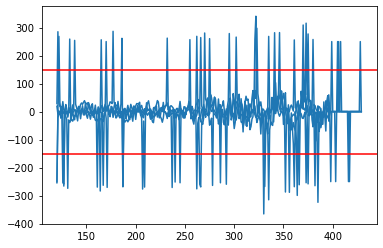

In [112]:
for df in dataframes:
    df['value'][120:430].plot.line(color='tab:blue')
plt.axhline(y=150, color='r')
plt.axhline(y=-150, color='r')

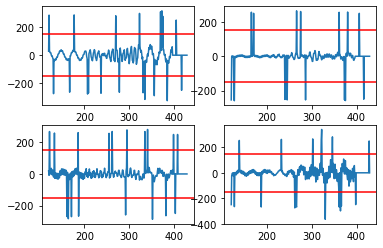

In [113]:
fig, axs = plt.subplots(2,2)
for ax, df in zip(axs.flat, dataframes):
    ax.plot(df['value'][120:430])
    ax.axhline(y=150, color='r')
    ax.axhline(y=-150, color='r')


Converting timestamps to UNIX epoch time in integer format. This is necessary because numpy arrays require homogeneous data types, i.e. all integers, or all datetimes, but not both in the same array.

In [114]:
for idx, df in enumerate(dataframes):
    df = df['timestamp'].view('int64')
    dataframes[idx]['timestamp'] = df

## Removing outliers
Outliers will have their value replaced with NaN (not a number), but the rows containing the outliers will remain inplace to maintain the shape of the data. Replacing outliers with NaN means the outliers will be ignored in calculations and visualizations, but they will still exist in the array so that all the dimensions will line up.

In [115]:
def find_outliers(df: pd.DataFrame, col: str) -> pd.Series:
    """Returns a Pandas Series of boolean values where true indicates the presence of an outlier"""
    sigma = df[col].std()
    mean = df[col].mean()
    cutoff = 3*sigma
    is_outlier = ((df[col] > mean + cutoff) | (df[col] < mean - cutoff))
    return is_outlier

Identifying outliers.

In [116]:
outliers = []
for df in dataframes:
    outliers.append(find_outliers(df, 'value'))
    

Replacing outliers with NaN.

In [117]:
for df, is_ol in zip(dataframes, outliers):
    df.loc[is_ol, 'value'] = np.NaN

The data is now free of outliers.

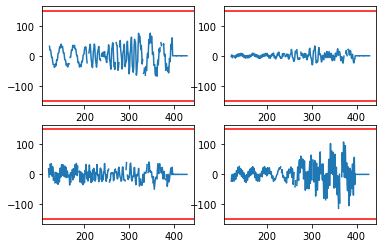

In [118]:
fig, axs = plt.subplots(2,2)
for ax, df in zip(axs.flat, dataframes):
    ax.plot(df['value'][120:430])
    ax.axhline(y=150, color='r')
    ax.axhline(y=-150, color='r')

## Preparing Dimensions/Coords
The dimensions will be time, machine ID, and feature.
The shape of the array will be 3000 x 20 x 4 for time, machine ID, and feature, respectively.

Getting times.

This assumes all timestamps are the same across all machines and features.

In [119]:
times = dataframes[0]['timestamp'].unique()
times.shape

(3000,)

Getting machine ID's.

In [120]:
machine_ids = dataframes[0]['machine'].unique()
machine_ids.shape

(20,)

Getting features.

In [121]:
# The features are simply the names of the first four tables,
# which were already fetched earlier
features = np.array(tables[:4])
features.shape

(4,)

## Creating 3D array
Moving data from flat dataframe to 3000 x 20 x 4 numpy array.

In [122]:
data = np.zeros((3000, 20, 0))
for df in dataframes:
    temp = np.transpose(np.resize(df['value'], (20, 3000)))
    data = np.dstack((data, temp))
data[:20, 0, 1]

array([ 8.80311979,  2.81632702, -0.67264459,  6.52513151,  3.69135874,
       -3.52242643,  1.91652192,  3.2046286 , -5.46043118, -3.32576734,
        1.81505119,         nan, -7.31330813,         nan, -3.53748469,
       -8.55967177, -0.98411214,  0.0571199 , -6.74948646, -1.45939881])

Creating xarray with labeled dimentions and coords

In [123]:
dims = ['time', 'machine_id', 'feature']
coords = [times, machine_ids, features]
data_xr = xr.DataArray(data, dims=dims, coords=coords)

In [124]:
# The first 20 datapoints of machine_0, feat_1
data_xr[:20, 0, 1]

<xarray.DataArray (time: 20)>
array([ 8.80311979,  2.81632702, -0.67264459,  6.52513151,  3.69135874,
       -3.52242643,  1.91652192,  3.2046286 , -5.46043118, -3.32576734,
        1.81505119,         nan, -7.31330813,         nan, -3.53748469,
       -8.55967177, -0.98411214,  0.0571199 , -6.74948646, -1.45939881])
Coordinates:
  * time        (time) int64 1546300800000000000 ... 1546848182460820000
    machine_id  <U9 'machine_0'
    feature     <U6 'feat_1'